# Copyright Netherlands eScience Center <br>
**Function     : Testing BayesConvLSTM with Lorens-84 model - Long lead time and metric** <br>
**Author       : Yang Liu** <br>
**First Built  : 2020.03.31** <br>
**Last Update  : 2020.06.25** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to help understand the uncertainty generated by BayesConvLSTM with the sensitivity tests with Lorens 84 model. <br>

Three different types of uncertainties will vbe investigated here:<br>
- uncertainty of model outcome attributed to perturbation in initial conditions
- model uncertainty
- uncertainty related to extra/bias/trend terms

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
#import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
#sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# sensitivity test parameter
#sense = 'x'
sense = 'a'
#sense = 'G'
# model type
model_type = 'lorenz84ex' # choose lorenz84 or lorenz84ex
# datapath for output
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84'
# datapath of forecast
if model_type == 'lorenz84':
    pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100'
    #pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries\\penalty100_stdx4'
elif model_type == 'lorenz84ex':
    pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\longLeadTime'
    #pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\ens40'
    #pred_lorenz_bayesconvlstm_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\penalty100\\ens80'
else:
    raise IOError("The chosen model type is not supported for sensitivity experiment!")

In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 200

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>

##### Testing 
- Testing initial conditions x, y, z - uncertainty of model outcome <br>
**starting point x=1.0, y=1.0, z=1.0** <br>
Ensemble variant x 50 members <br>
x = [1.0020 : 0.9980] **~0.2%**<br>
x = [1.0010 : 0.9990] **~0.1%**<br>
x = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.0010 : 0.9990] **~0.1%**<br>
x_ex = [1.00010 : 0.99990] **~0.01%**<br>
x_ex = [1.000010 : 0.999990] **~0.001%**<br>
========================================================================================================<br>
- Testing model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a = [0.25010 : 0.24990] **~0.04%**<br>
a_ex = [0.250010 : 0.249990] **~0.004%**<br>
a_ex = [0.2500010 : 0.2499990] **~0.0004%**<br>
========================================================================================================<br>
- Testing external forcing terms F & G - uncertainty related to extra/bias/trend terms <br>
**starting point F=8.0, G=1.0** <br>
Ensemble variant G <br>
G = [1.0010 : 0.9990] **~0.1%**<br>
G_ex = [1.00010 : 0.99990] **~0.01%**<br>
G_ex = [1.000010 : 0.999990] **~0.001%**<br>
**starting point F=8.0, G=1.0, epsilon=0.4** <br>

In [6]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        Physical interpretation:
        x represents the intensity of the symmetric globe-encircling westerly
        wind current, and also the poleward temperature gradient, which is assumed
        to be in permanent equilibrium with it.
        
        y and z represent the cosine and sine phases of a chain of superposed
        large-scale eddies, which transport heat poleward at a rate proportional
        to the square of their amplitude, and transport no angular momentum at all.
        (Lorenz identifies the eddies with Rossby waves!)
        
        xy and xz these nonlinear contributions represent amplification of the
        eddies through interaction with the westerly current
        
        -y**2 and -z**2 are the expense of the westerly current for the amplification
        of the eddies.
        
        -bxz and bxy represent displacement of the eddies by the westerly current.
        
        b allows the amplification (should be b>1.0)
        
        a represents mechanical and thermal damping(should be a>1.0).
        
        aF represents symmetric thermal forcing
        G represents asymmetric thermal forcing
        
        !@#$%^&* The variables have been scaled so that the coefficients are unity.
        
        Freire, J. G., Bonatto, C., DaCamara, C. C., & Gallas, J. A. (2008).
        Multistability, phase diagrams, and intransitivity in the Lorenz-84
        low-order atmospheric circulation model. Chaos: An Interdisciplinary
        Journal of Nonlinear Science, 18(3), 033121.
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz
    
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########                 Launch Lorenz 84 model                    ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84(x[i], y[i], z[i], a, b ,F, G)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)

In [7]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

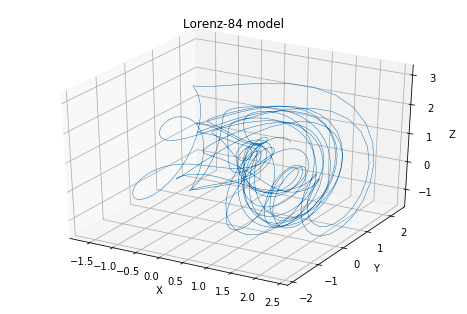

<Figure size 432x288 with 0 Axes>

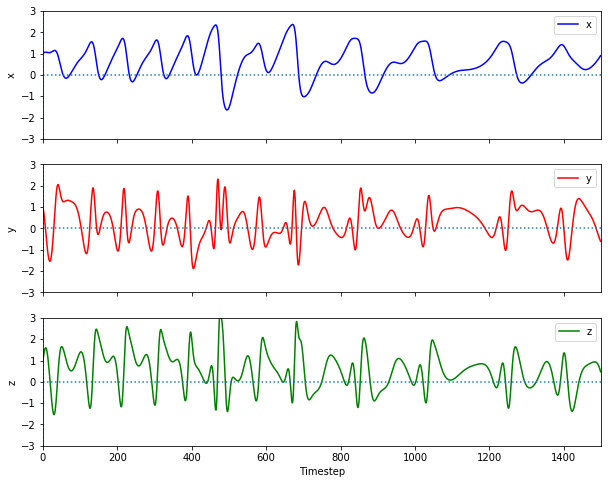

In [8]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [10]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std
    x_std = np.std(x)
    y_std = np.std(y)
    z_std = np.std(z)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================


In [11]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 730 # unit time step
    # number of ensembles
    ens = 20
    predictand = np.zeros((ens, 3, test_len, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred = Dataset(os.path.join(pred_lorenz_bayesconvlstm_path,
                                            'pred_lorenz84_ens_{}.nc'.format(i)))
                                            #'pred_lorenz84_ens40_ens_{}.nc'.format(i)))
                                            #'pred_lorenz84_ens80_ens_{}.nc'.format(i)))
        predictand[i,:,:,:] = dataset_pred.variables['series'][:]
    print(predictand.shape)
    predictand_median = np.median(predictand, 0)

*******************  load ensemble data  *********************
(20, 3, 200, 730)


===================  visualize data  =====================


<Figure size 432x288 with 0 Axes>

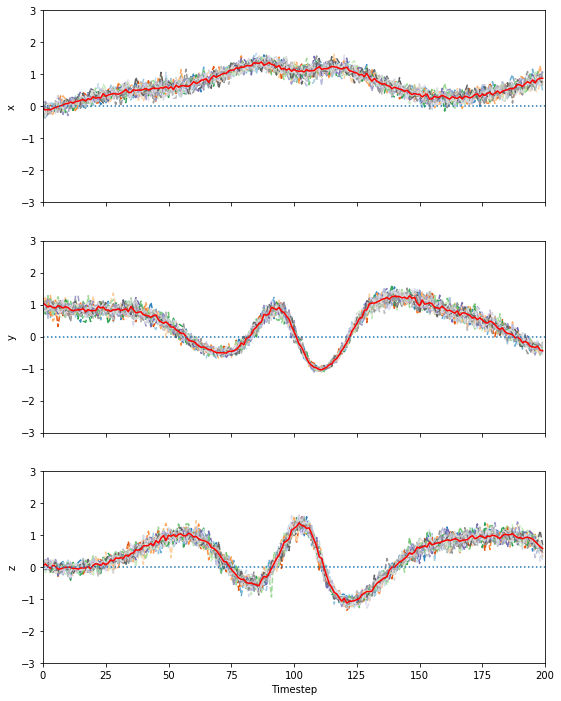

In [12]:
    #######################################################################
    ########    visualization of lead time dependent prediction    ########
    #######################################################################
    index = np.arange(test_len)
    
    print ('===================  visualize data  =====================')
    #colormap=cm.Pastel2(range(ens))
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', 51)
    #colormap = plt.get_cmap('jet', 40)
    
    fig03 = plt.figure()
    fig03, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig03.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        ax1.plot(index, predictand[i, 0, :, 0] * (x_max - x_min) + x_min,
                 color=colormap[i], linestyle='dashed', label='x ens {}'.format(i))
        ax2.plot(index, predictand[i, 1, :, 0] * (y_max - y_min) + y_min,
                 color=colormap[i], linestyle='dashed', label='y ens {}'.format(i))
        ax3.plot(index, predictand[i, 2, :, 0] * (z_max - z_min) + z_min,
                 color=colormap[i], linestyle='dashed', label='z ens {}'.format(i))
    # median
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    #ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    #ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    #ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")

    plt.show()
    fig03.savefig(os.path.join(output_path,
                               'BayesConvLSTM_forecast_lorenz84_series_ens_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)    

<Figure size 432x288 with 0 Axes>

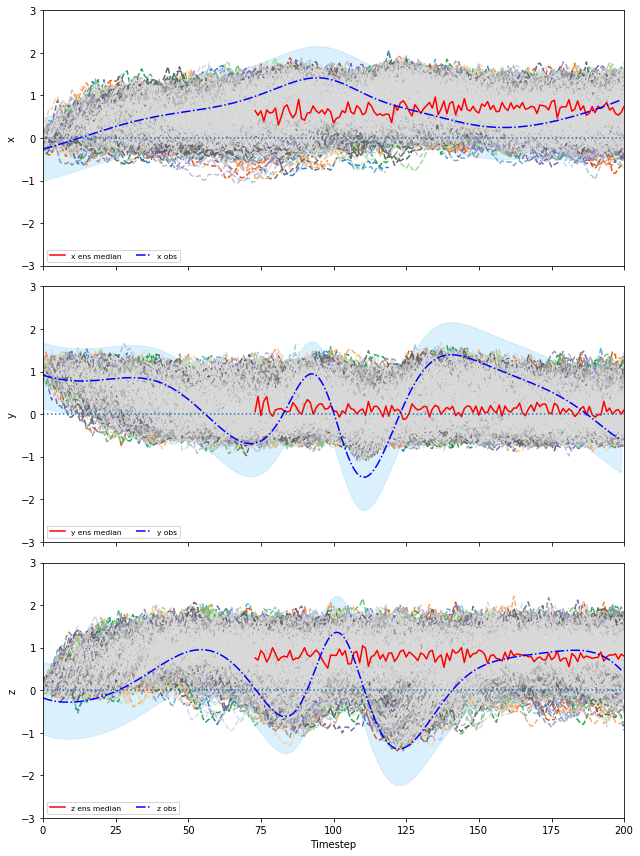

In [17]:
    ##################################################################################################
    ########    visualization of lead time dependent prediction - timeseries with lead time   ########
    ##################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    step_lead_display = 73
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead_display)
    
    fig06 = plt.figure()
    fig06, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig06.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        for j in range(test_len):
            ax1.plot(index_lead[j:j+step_lead_display], predictand[i, 0, j, :step_lead_display] * (x_max - x_min) + x_min,
                     color=colormap[i], linestyle='dashed')
            ax2.plot(index_lead[j:j+step_lead_display], predictand[i, 1, j, :step_lead_display] * (y_max - y_min) + y_min,
                     color=colormap[i], linestyle='dashed')
            ax3.plot(index_lead[j:j+step_lead_display], predictand[i, 2, j, :step_lead_display] * (z_max - z_min) + z_min,
                     color=colormap[i], linestyle='dashed')

    # median
    ax1.plot(index_lead[step_lead_display:], predictand_median[0, :, step_lead_display-1] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median')
    ax2.plot(index_lead[step_lead_display:], predictand_median[1, :, step_lead_display-1] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median')
    ax3.plot(index_lead[step_lead_display:], predictand_median[2, :, step_lead_display-1] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median')

    # obs
    ax1.plot(index, x[-test_len:], color='blue', linestyle='dashdot', label='x obs')
    ax2.plot(index, y[-test_len:], color='blue', linestyle='dashdot', label='y obs')
    ax3.plot(index, z[-test_len:], color='blue', linestyle='dashdot', label='z obs')
    # obs std band
    ax1.fill_between(index, x[-test_len:] + x_std, x[-test_len:] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index, y[-test_len:] + y_std, y[-test_len:] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index, z[-test_len:] + z_std, z[-test_len:] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len)
    ax2.set_xlim(0, test_len)
    ax3.set_xlim(0, test_len)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    if sense == 'x':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_leadTime{}_a{}_b{}_F{}_G{}.png'.format(step_lead_display,a, b, F, G)),dpi=200)
    elif sense == 'a':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_leadTime{}_x{}_b{}_F{}_G{}.png'.format(step_lead_display,x_init, b, F, G)),dpi=200)
    elif sense == 'G':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_leadTime{}_x{}_a{}_b{}_F{}.png'.format(step_lead_display,x_init, a, b, F)),dpi=200)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

In [13]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

<Figure size 432x288 with 0 Axes>

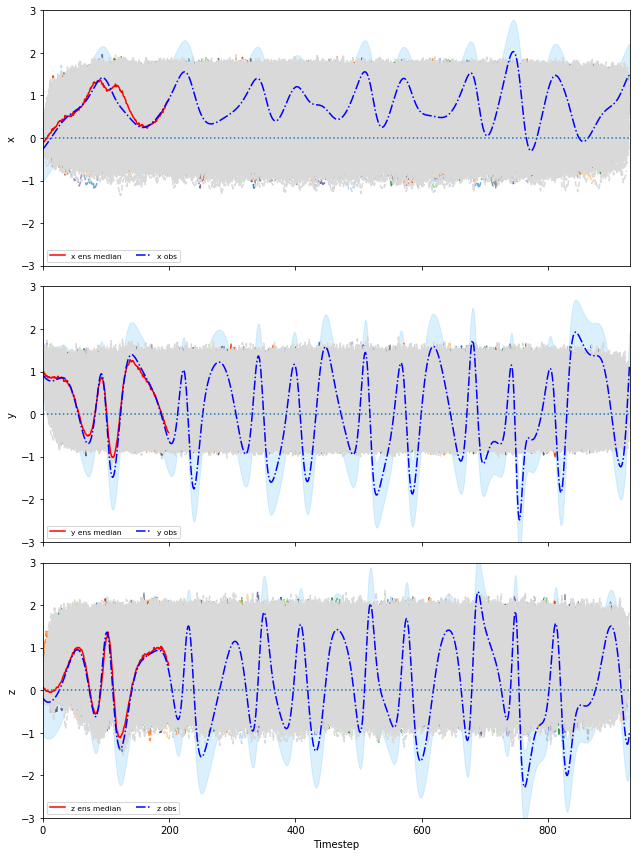

In [16]:
    #######################################################################################################
    ########    visualization of lead time dependent prediction - long timeseries with lead time   ########
    #######################################################################################################
    #colormap=cm.Accent(range(ens))
    #colormap=cm.Set1(range(ens))
    #colormap=cm.tab10(range(ens))
    colormap=cm.tab20c(range(ens))
    #colormap=cm.jet(range(ens))
    
    # Get colors from colormap
    #colormap = plt.get_cmap('coolwarm', step_lead)
    #colormap = plt.get_cmap('jet', 51)
    
    index = np.arange(test_len)
    index_lead = np.arange(test_len + step_lead)
    
    fig06 = plt.figure()
    fig06, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig06.set_size_inches(9, 12, forward=True)
    # each member
    for i in range(ens):
        for j in range(test_len):
            ax1.plot(index_lead[j:j+step_lead], predictand[i,0,j,:] * (x_max - x_min) + x_min,
                     color=colormap[i], linestyle='dashed')
            ax2.plot(index_lead[j:j+step_lead], predictand[i,1,j,:] * (y_max - y_min) + y_min,
                     color=colormap[i], linestyle='dashed')
            ax3.plot(index_lead[j:j+step_lead], predictand[i,2,j,:] * (z_max - z_min) + z_min,
                     color=colormap[i], linestyle='dashed')

    # median
    ax1.plot(index, predictand_median[0, :, 0] * (x_max - x_min) + x_min,
             color='red', linestyle='solid', label='x ens median')
    ax2.plot(index, predictand_median[1, :, 0] * (y_max - y_min) + y_min,
             color='red', linestyle='solid', label='y ens median')
    ax3.plot(index, predictand_median[2, :, 0] * (z_max - z_min) + z_min,
             color='red', linestyle='solid', label='z ens median')

    # obs
    ax1.plot(index_lead, xx[-(test_len + step_lead):], color='blue', linestyle='dashdot', label='x obs')
    ax2.plot(index_lead, yy[-(test_len + step_lead):], color='blue', linestyle='dashdot', label='y obs')
    ax3.plot(index_lead, zz[-(test_len + step_lead):], color='blue', linestyle='dashdot', label='z obs')
    
    # obs std band
    ax1.fill_between(index_lead, xx[-(test_len + step_lead):] + x_std, xx[-(test_len + step_lead):] - x_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax2.fill_between(index_lead, yy[-(test_len + step_lead):] + y_std, yy[-(test_len + step_lead):] - y_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    ax3.fill_between(index_lead, zz[-(test_len + step_lead):] + z_std, zz[-(test_len + step_lead):] - z_std,
                     alpha=0.3,edgecolor='lightskyblue', facecolor='lightskyblue')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)

    ax1.set_xlim(0, test_len + step_lead)
    ax2.set_xlim(0, test_len + step_lead)
    ax3.set_xlim(0, test_len + step_lead)
    
    ax1.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax2.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)
    ax3.legend(frameon=True, loc=3, prop={'size': 7.5}, ncol=7)

    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Timestep")
    
    plt.tight_layout()

    plt.show()
    if sense == 'x':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_longLeadTime_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)
    elif sense == 'a':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_longLeadTime_x{}_b{}_F{}_G{}.png'.format(x_init, b, F, G)),dpi=200)
    elif sense == 'G':
        fig06.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_series_ens_longLeadTime_x{}_a{}_b{}_F{}.png'.format(x_init, a, b, F)),dpi=200)
    else:
        raise IOError("The chosen variable is not supported for sensitivity experiment!")

- Perturb model parameters a & b - model uncertainty <br>
**starting point a=0.25, b=4.0** <br>
Ensemble variant a <br>
a_ex = 0.2x **~20%**<br>
a_ex = 0.24x **~4%**<br>
a_ex = 0.25x **~1%**<br>

In [14]:
    ##############################################################################################################
    ###########       Lead time dependent forecast with perturbed Lorenz 84 model - perturbation a     ###########
    ##############################################################################################################
    # perturbation intensity
    a_pool = np.array([0.241, 0.242, 0.243, 0.244, 0.245, 0.246, 0.247],dtype=float)
    #a_pool = np.array([0.20, 0.21, 0.22, 0.23, 0.24],dtype=float)
    #a_pool = np.array([0.231, 0.232, 0.233, 0.234, 0.235, 0.236, 0.237, 0.238],dtype=float)
    
    ens_perturb = len(a_pool)
    
    forecast_perturb_Lorenz = np.zeros((ens_perturb, 3, test_len, step_lead), dtype=float)
    for n in range(ens_perturb):
        a = a_pool[n]
        for t in range(test_len):
            # Need one more for the initial values
            x_interim = np.empty(step_lead+1)
            y_interim = np.empty(step_lead+1)
            z_interim = np.empty(step_lead+1)
            tt = 0.0
            
            x_interim[0] = x[-test_len-1+t]
            y_interim[0] = y[-test_len-1+t]
            z_interim[0] = z[-test_len-1+t]
            
            for i in range(step_lead):
                dx, dy, dz = lorenz84_ex(x_interim[i], y_interim[i], z_interim[i], tt, a, b ,F, G, epsilon)
                x_interim[i + 1] = x_interim[i] + (dx * dt)
                y_interim[i + 1] = y_interim[i] + (dy * dt)
                z_interim[i + 1] = z_interim[i] + (dz * dt)
                tt += dt
            
            forecast_perturb_Lorenz[n, 0, t, :] = x_interim[1:]
            forecast_perturb_Lorenz[n, 1, t, :] = y_interim[1:]
            forecast_perturb_Lorenz[n, 2, t, :] = z_interim[1:]

In [18]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # lead time dependent CRPS
    crps = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        _, crps[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i], predictand[:,0,:,i]* (x_max - x_min) + x_min)
        _, crps[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i], predictand[:,1,:,i]* (y_max - y_min) + y_min)
        _, crps[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i], predictand[:,2,:,i]* (z_max - z_min) + z_min)
    
    # lead time dependent CRPS of perturbed Lorenz 84 model
    crps_perturb = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        _, crps_perturb[i,0] = dlacs.metric.CRPS(xx[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[:,0,:,i])
        _, crps_perturb[i,1] = dlacs.metric.CRPS(yy[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[:,1,:,i])
        _, crps_perturb[i,2] = dlacs.metric.CRPS(zz[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[:,2,:,i])

<Figure size 432x288 with 0 Axes>

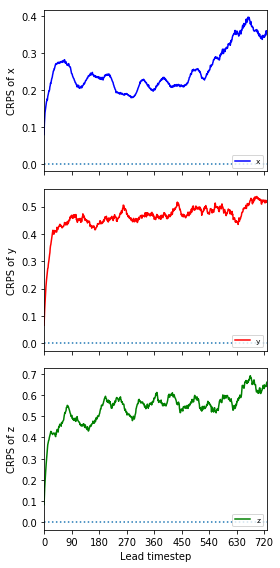

In [19]:
    ##############################################################################################################
    ###########       Compute CRPS with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "CRPS_longLeadTime.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z" , "BayesLSTM"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(crps.T)
        writer.writerow(["x", "y", "z" , "Perturb Lorenz 84"])  # write header
        writer.writerows(crps_perturb.T)
        
    index = np.arange(0, step_lead)
    
    fig07 = plt.figure()
    fig07, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig07.set_size_inches(4, 8, forward=True)
    
    # crps of perturbed Lorenz 84 model forecast
#     ax1.plot(np.arange(step_lead), crps_perturb[:,0], 'lightblue', label='x perturb')
#     ax2.plot(np.arange(step_lead), crps_perturb[:,1], 'lightcoral', label='y perturb')
#     ax3.plot(np.arange(step_lead), crps_perturb[:,2], 'lightgreen', label='z perturb')      
    # forecast
    ax1.plot(np.arange(step_lead), crps[:,0], 'b', label='x')
    ax2.plot(np.arange(step_lead), crps[:,1], 'r', label='y')
    ax3.plot(np.arange(step_lead), crps[:,2], 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, step_lead)
    ax2.set_xlim(0, step_lead)
    ax3.set_xlim(0, step_lead)
    
    ax1.set_xticks(np.arange(0,step_lead,90))
    ax2.set_xticks(np.arange(0,step_lead,90))
    ax3.set_xticks(np.arange(0,step_lead,90))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax2.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax3.legend(frameon=True, prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig07.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_CRPS_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig07.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_CRPS_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig07.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_CRPS_longLeadTime_comp.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")

<Figure size 432x288 with 0 Axes>

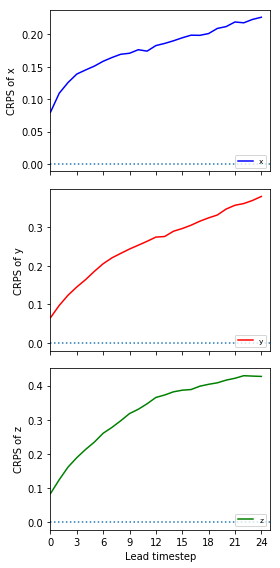

In [20]:
    fig08 = plt.figure()
    fig08, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig08.set_size_inches(4, 8, forward=True)
    
    display_upto = 25
    
    # crps of perturbed Lorenz 84 model forecast
#     ax1.plot(np.arange(display_upto), crps_perturb[:display_upto,0], 'lightblue', label='x perturb')
#     ax2.plot(np.arange(display_upto), crps_perturb[:display_upto,1], 'lightcoral', label='y perturb')
#     ax3.plot(np.arange(display_upto), crps_perturb[:display_upto,2], 'lightgreen', label='z perturb')      
    # forecast
    ax1.plot(np.arange(display_upto), crps[:display_upto,0], 'b', label='x')
    ax2.plot(np.arange(display_upto), crps[:display_upto,1], 'r', label='y')
    ax3.plot(np.arange(display_upto), crps[:display_upto,2], 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto,3))
    ax2.set_xticks(np.arange(0,display_upto,3))
    ax3.set_xticks(np.arange(0,display_upto,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("CRPS of x")
    ax2.set_ylabel("CRPS of y")
    ax3.set_ylabel("CRPS of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax2.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax3.legend(frameon=True, prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig08.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_CRPS_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig08.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_CRPS_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig08.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_CRPS_longLeadTime_comp_zoomIn.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")

In [15]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_ens = np.zeros((ens, step_lead, 3), dtype=float)
    for i in range(step_lead):
        for n in range(ens):
            rmse_x = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], predictand[n,0,:,i]* (x_max - x_min) + x_min)
            rmse_y = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], predictand[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], predictand[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_ens[n,i,0] = rmse_x
            rmse_ens[n,i,1] = rmse_y
            rmse_ens[n,i,2] = rmse_z
            
    rmse = np.mean(rmse_ens, 0)
    
    # lead time dependent RMSE of perturbation
    rmse_ens_perturb = np.zeros((ens_perturb, step_lead, 3), dtype=float)
    for i in range(step_lead):
        for n in range(ens_perturb):
            rmse_x = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[n,0,:,i])
            rmse_y = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[n,0,:,i])
            rmse_z = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[n,0,:,i])
            
            rmse_ens_perturb[n,i,0] = rmse_x
            rmse_ens_perturb[n,i,1] = rmse_y
            rmse_ens_perturb[n,i,2] = rmse_z
            
    rmse_perturb = np.mean(rmse_ens_perturb, 0)    
    
    # lead time dependent RMSE of persistence
    rmse_persist = np.zeros((step_lead,3), dtype=float)
    for i in range(step_lead):
        rmse_persist[i,0] = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i], xx[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i,1] = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i], yy[-(test_len + step_lead)-1:-step_lead-1])
        rmse_persist[i,2] = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i], zz[-(test_len + step_lead)-1:-step_lead-1])

<Figure size 432x288 with 0 Axes>

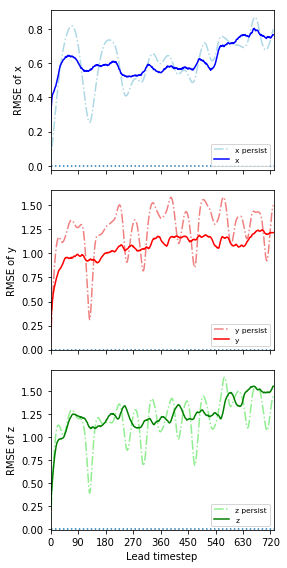

In [16]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "RMSE_longLeadTime.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["x", "y", "z", "BayesLSTM"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerows(rmse.T)
        writer.writerow(["x", "y", "z", "Perturb Lorenz 84"])
        writer.writerows(rmse_perturb.T)
        writer.writerow(["x", "y", "z", "Persistence"])
        writer.writerows(rmse_persist.T)
        
    index = np.arange(0, step_lead)
    
    fig09 = plt.figure()
    fig09, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig09.set_size_inches(4, 8, forward=True)
    
    # rmse of persistence
    ax1.plot(np.arange(step_lead), rmse_persist[:,0], color = 'lightblue', linestyle='dashdot', label='x persist')
    ax2.plot(np.arange(step_lead), rmse_persist[:,1], color = 'lightcoral', linestyle='dashdot', label='y persist')
    ax3.plot(np.arange(step_lead), rmse_persist[:,2], color = 'lightgreen', linestyle='dashdot', label='z persist')
    # rmse of perturbed Lorenz 84 model
#     ax1.plot(np.arange(step_lead), rmse_perturb[:,0], color = 'lightblue', linestyle='dashed', label='x perturb')
#     ax2.plot(np.arange(step_lead), rmse_perturb[:,1], color = 'lightcoral', linestyle='dashed', label='y perturb')
#     ax3.plot(np.arange(step_lead), rmse_perturb[:,2], color = 'lightgreen', linestyle='dashed', label='z perturb')
    # rmse of forecast
    ax1.plot(np.arange(step_lead), rmse[:,0], 'b', label='x')
    ax2.plot(np.arange(step_lead), rmse[:,1], 'r', label='y')
    ax3.plot(np.arange(step_lead), rmse[:,2], 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, step_lead)
    ax2.set_xlim(0, step_lead)
    ax3.set_xlim(0, step_lead)
    
    ax1.set_xticks(np.arange(0,step_lead,90))
    ax2.set_xticks(np.arange(0,step_lead,90))
    ax3.set_xticks(np.arange(0,step_lead,90))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax2.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax3.legend(frameon=True, prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig09.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_RMSE_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig09.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_RMSE_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig09.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_RMSE_longLeadTime_comp.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")

<Figure size 432x288 with 0 Axes>

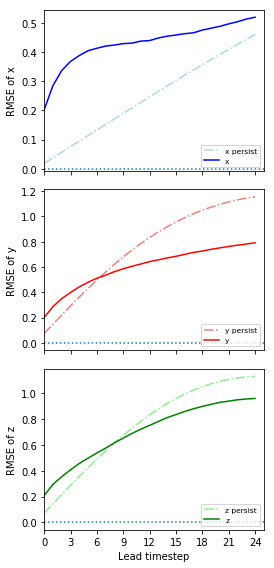

In [17]:
    # zoom in
    fig10 = plt.figure()
    fig10, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig10.set_size_inches(4, 8, forward=True)
    
    display_upto = 25
    
    # rmse of persistence
    ax1.plot(np.arange(display_upto), rmse_persist[:display_upto,0], color = 'lightblue', linestyle='dashdot', label='x persist')
    ax2.plot(np.arange(display_upto), rmse_persist[:display_upto,1], color = 'lightcoral', linestyle='dashdot', label='y persist')
    ax3.plot(np.arange(display_upto), rmse_persist[:display_upto,2], color = 'lightgreen', linestyle='dashdot', label='z persist')
    # rmse of perturbed Lorenz 84 model
#     ax1.plot(np.arange(display_upto), rmse_perturb[:display_upto,0], color = 'lightblue', linestyle='dashed', label='x perturb')
#     ax2.plot(np.arange(display_upto), rmse_perturb[:display_upto,1], color = 'lightcoral', linestyle='dashed', label='y perturb')
#     ax3.plot(np.arange(display_upto), rmse_perturb[:display_upto,2], color = 'lightgreen', linestyle='dashed', label='z perturb')
    # rmse of forecast
    ax1.plot(np.arange(display_upto), rmse[:display_upto,0], 'b', label='x')
    ax2.plot(np.arange(display_upto), rmse[:display_upto,1], 'r', label='y')
    ax3.plot(np.arange(display_upto), rmse[:display_upto,2], 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto,3))
    ax2.set_xticks(np.arange(0,display_upto,3))
    ax3.set_xticks(np.arange(0,display_upto,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x")
    ax2.set_ylabel("RMSE of y")
    ax3.set_ylabel("RMSE of z")
    
    plt.xlabel("Lead timestep")
    
    ax1.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax2.legend(frameon=True, prop={'size': 7.5}, loc=4)
    ax3.legend(frameon=True, prop={'size': 7.5}, loc=4)
    
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig10.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_RMSE_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig10.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_RMSE_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig10.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_RMSE_longLeadTime_comp_zoomIn.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")    

In [18]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_ens = np.zeros((ens, step_lead), dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_denorm = np.zeros(predictand.shape, dtype=float)
    predictand_denorm[:,0,:,:] = predictand[:,0,:,:] * (x_max - x_min) + x_min
    predictand_denorm[:,1,:,:] = predictand[:,1,:,:] * (y_max - y_min) + y_min
    predictand_denorm[:,2,:,:] = predictand[:,2,:,:] * (z_max - z_min) + z_min
    
    for i in range(step_lead):
        for n in range(ens):
            euclidean_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], predictand_denorm[n,:,:,i])
            euclidean_ens[n,i] = euclidean_n
            
    euclidean = np.mean(euclidean_ens, 0)
    
    # lead time dependent Euclidean distance of persistence
    euclidean_persist = np.zeros(step_lead, dtype=float)
    for i in range(step_lead):
        euclidean_persist[i] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], obs[:,-(test_len + step_lead)-1:-step_lead-1])
    
    # lead time dependent Euclidean distance of perturbed Lorenz 84 model
    euclidean_ens_perturb = np.zeros((ens_perturb, step_lead), dtype=float)
    
    for i in range(step_lead):
        for n in range(ens_perturb):
            euclidean_n = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i], forecast_perturb_Lorenz[n,:,:,i])
            euclidean_ens_perturb[n,i] = euclidean_n
            
    euclidean_perturb = np.mean(euclidean_ens_perturb, 0)

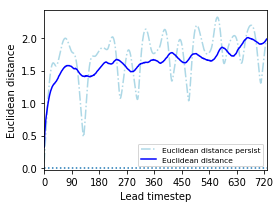

In [19]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Write CSV file
    with open(os.path.join(output_path, "EuclideanD_longLeadTime.csv"), "wt+") as fp:
        writer = csv.writer(fp, delimiter=",")
        writer.writerow(["Euclidean", "BayesLSTM"])  # write header
        writer.writerow(np.arange(step_lead))  # write header
        writer.writerow(euclidean)
        writer.writerow(["Euclidean", "Perturb Lorenz 84"])  # write header
        writer.writerow(euclidean_perturb)
        writer.writerow(["Euclidean", "Persistence"])  # write header
        writer.writerow(euclidean_persist)
        
    index = np.arange(0, step_lead)
    
    fig11 = plt.figure()
    fig11.set_size_inches(4, 3, forward=True)
    plt.plot(np.arange(step_lead), euclidean_persist[:], color = 'lightblue', linestyle='dashdot', label='Euclidean distance persist')
#     plt.plot(np.arange(step_lead), euclidean_perturb[:], color = 'lightblue', linestyle='dashed', label='Euclidean distance perturb')
    plt.plot(np.arange(step_lead), euclidean[:], 'b', label='Euclidean distance')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, step_lead)
    plt.xticks(np.arange(0,step_lead,90))
    
    #plt.ylim(0, 0.5)    
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead timestep")
    
    plt.legend(frameon=True, prop={'size': 7.5}, loc=4)
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig11.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_EuclideanD_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig11.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_EuclideanD_longLeadTime_comp.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig11.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_EuclideanD_longLeadTime_comp.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")

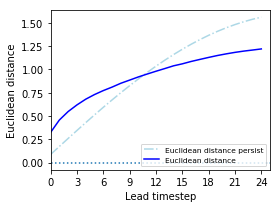

In [20]:
    # zoom in
    display_upto = 25
    
    fig12 = plt.figure()
    fig12.set_size_inches(4, 3, forward=True)
    plt.plot(np.arange(display_upto), euclidean_persist[:display_upto], color = 'lightblue', linestyle='dashdot', label='Euclidean distance persist')
#     plt.plot(np.arange(display_upto), euclidean_perturb[:display_upto], color = 'lightblue', linestyle='dashed', label='Euclidean distance perturb')
    plt.plot(np.arange(display_upto), euclidean[:display_upto], 'b', label='Euclidean distance')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto,3))
    
    #plt.ylim(0, 0.5)    
    plt.ylabel("Euclidean distance")
    plt.xlabel("Lead timestep")
    
    plt.legend(frameon=True, prop={'size': 7.5}, loc=4)
    plt.tight_layout()

    plt.show()
    if model_type == 'lorenz84':
        fig12.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_lorenz84_EuclideanD_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84ex':
        fig12.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_ex_lorenz84_EuclideanD_longLeadTime_comp_zoomIn.png'),dpi=200)
    elif model_type == 'lorenz84AA':
        fig12.savefig(os.path.join(output_path,'BayesConvLSTM_forecast_AA_lorenz84_EuclideanD_longLeadTime_comp_zoomIn.png'),dpi=200)
    else:
         raise IOError("The chosen model type is not supported!")